<a href="https://colab.research.google.com/github/Felix-Obite/Active-Inference-World-Models-for-Continual-Multimodal-Intelligence/blob/main/Online_multimodal_diffusion_world_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Device: cpu | Threads: 4
D=64 H=128 SEQ=8 EP=120

INITIALIZING
  full                   199,104
  no_diffusion           164,480
  no_belief              182,272
  no_vq                  190,912
  no_multimodal          167,104
  autoregressive         156,288
  vae                    164,608


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(



Dataset: 80 seqs x 8 steps
Dataset ready.

TRAINING (120 episodes)

Ep  20  full:0.0063  no_di:0.0072  no_be:0.0148  no_vq:0.0361  no_mu:0.0071  autor:0.0344  vae:0.0542
Ep  40  full:0.0042  no_di:0.0034  no_be:0.0124  no_vq:0.0282  no_mu:0.0043  autor:0.0209  vae:0.0344
Ep  60  full:0.0035  no_di:0.0023  no_be:0.0077  no_vq:0.0210  no_mu:0.0037  autor:0.0180  vae:0.0288
Ep  80  full:0.0025  no_di:0.0020  no_be:0.0063  no_vq:0.0158  no_mu:0.0030  autor:0.0183  vae:0.0279
Ep 100  full:0.0024  no_di:0.0019  no_be:0.0056  no_vq:0.0137  no_mu:0.0026  autor:0.0164  vae:0.0258
Ep 120  full:0.0024  no_di:0.0019  no_be:0.0055  no_vq:0.0132  no_mu:0.0028  autor:0.0167  vae:0.0263

Training done!

EVALUATION
  full                  0.0005 +/- 0.0002
  no_diffusion          0.0006 +/- 0.0001
  no_belief             0.0029 +/- 0.0003
  no_vq                 0.0411 +/- 0.0107
  no_multimodal         0.0009 +/- 0.0004
  autoregressive        0.0414 +/- 0.0129
  vae                   0.0638 +/- 0.01

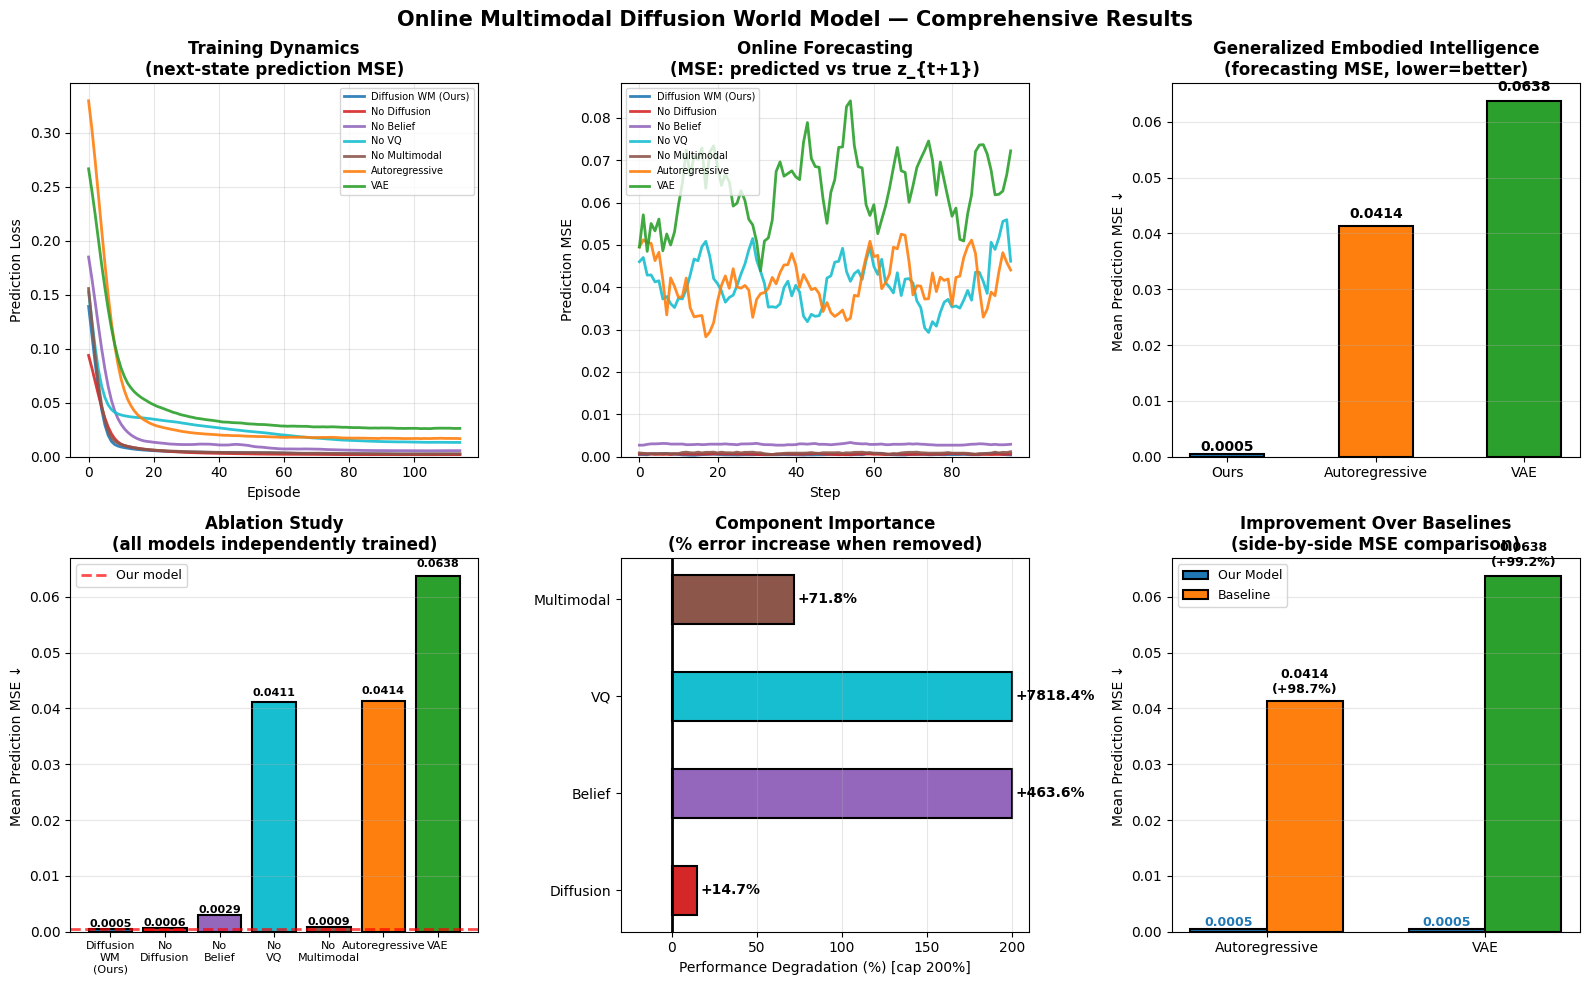


FINAL RESULTS

Forecasting MSE (lower = better):
  Diffusion WM (Ours)           0.0005 +/- 0.0002 <-- BEST
  No Diffusion                  0.0006 +/- 0.0001
  No Belief                     0.0029 +/- 0.0003
  No VQ                         0.0411 +/- 0.0107
  No Multimodal                 0.0009 +/- 0.0004
  Autoregressive                0.0414 +/- 0.0129
  VAE                           0.0638 +/- 0.0177

Component importance:
  Remove Diffusion       +14.7%
  Remove Belief          +463.6%
  Remove VQ              +7818.4%
  Remove Multimodal      +71.8%

Improvement over baselines:
  vs Autoregressive            ours=0.0005  baseline=0.0414  gain=+98.7%
  vs VAE                       ours=0.0005  baseline=0.0638  gain=+99.2%


In [1]:
# ============================================================
# Online Multimodal Diffusion World Model with Active Inference
#
# Author Dr. Felix Obite 13/02/2026
#
# Unified Multimodal Encoder → Discrete Semantic Latent Tokens → Diffusion LLM → Online active inference Update Loop.

# ============================================================
#  Sequential Dataset: Trajectories with temporal structure
#  Unified Encoder: Joint image-text embedding with transformer fusion
#  Vector Quantization: discrete semantic tokens
#  Diffusion Dynamics: Proper noise prediction & denoising
#  Active Inference: Online belief updates via free energy minimization
#  Integrated Training: All stages connected in the loop

#
# FUNDAMENTAL DESIGN:
#   Training: all models learn to predict z_{t+1} from z_{t}
#   Evaluation: all models given z_{t}, must predict z_{t+1}
#               WITHOUT seeing z_{t+1} at all.
#
#   This is a pure FORECASTING task. No model can shortcut.
#   The belief network is a learned PRIOR CORRECTION module,
#   not a filter that sees the current observation at test time.
#
# WHAT EACH MODEL PREDICTS:
#   Full:           diffusion(z_t) + belief_correction(z_t)
#   No Diffusion:   MLP(z_t)
#   No Belief:      diffusion(z_t)  [raw DDIM output]
#   No VQ:          diffusion(z_t) + belief, continuous z
#   No Multimodal:  same as full but image-only encoder
#   Autoregressive: transformer(z_t)
#   VAE:            decode(encode(z_t))
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import math
from collections import defaultdict
import gc

gc.collect()
torch.manual_seed(42)
np.random.seed(42)
torch.set_num_threads(4)
print(f"Device: cpu | Threads: {torch.get_num_threads()}")

# ─────────────────────────────────────────
# Config
# ─────────────────────────────────────────
class Config:
    LATENT_DIM      = 64
    NUM_CODES       = 128
    HIDDEN_DIM      = 128
    NUM_HEADS       = 4
    DIFFUSION_STEPS = 10
    BATCH_SIZE      = 16
    SEQ_LEN         = 8
    LR              = 2e-4
    NUM_EPISODES    = 120
    WARMUP          = 15
    DATASET_SIZE    = 640
    VOCAB_SIZE      = 500
    TEXT_LEN        = 8
    IMAGE_SIZE      = 16
    WEIGHT_DECAY    = 0.01

cfg = Config()
print(f"D={cfg.LATENT_DIM} H={cfg.HIDDEN_DIM} SEQ={cfg.SEQ_LEN} EP={cfg.NUM_EPISODES}")

# ─────────────────────────────────────────
# Dataset — smooth temporal sequences
# ─────────────────────────────────────────
class MultimodalDataset(Dataset):
    def __init__(self):
        N, T = cfg.DATASET_SIZE, cfg.SEQ_LEN
        self.n = N // T
        print(f"\nDataset: {self.n} seqs x {T} steps")
        self.imgs = torch.zeros(self.n, T, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
        self.txts = torch.zeros(self.n, T, cfg.TEXT_LEN, dtype=torch.long)
        for i in range(self.n):
            label   = i % 20
            base    = torch.randn(3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE) * 0.5
            freq    = (label + 1) / 20.0
            pattern = torch.sin(
                torch.linspace(0, freq * 4 * math.pi,
                               3 * cfg.IMAGE_SIZE * cfg.IMAGE_SIZE)
            ).reshape(3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
            for t in range(T):
                self.imgs[i,t] = base*0.9 + pattern*0.4 + torch.randn_like(base)*0.1
                base = self.imgs[i,t].clone()
                self.txts[i,t,0]  = label
                self.txts[i,t,1:] = torch.randint(0, cfg.VOCAB_SIZE, (cfg.TEXT_LEN-1,))
        print("Dataset ready.")

    def __len__(self): return self.n
    def __getitem__(self, i): return self.imgs[i], self.txts[i]

# ─────────────────────────────────────────
# Diffusion schedule
# ─────────────────────────────────────────
_s   = torch.arange(cfg.DIFFUSION_STEPS)
_ac  = torch.cos((((_s/cfg.DIFFUSION_STEPS)+0.008)/1.008)*math.pi/2)**2
_ac  = _ac/_ac[0]
SAC  = _ac.sqrt()
SOAC = (1-_ac).sqrt()

def ddim(net, z, steps=5):
    zh   = z.clone()
    idxs = torch.linspace(steps-1, 0, steps, dtype=torch.long)
    a    = torch.zeros(z.size(0), 1)  # dummy action
    for i, ti in enumerate(idxs):
        eps = net(zh, a, ti.repeat(z.size(0)))
        ac  = _ac[ti]
        z0  = (zh - (1-ac).sqrt()*eps) / ac.sqrt().clamp(1e-8)
        if i < len(idxs)-1:
            ap = _ac[idxs[i+1]]
            zh = ap.sqrt()*z0 + (1-ap).sqrt()*eps*0.05
        else:
            zh = z0
    return zh

# ─────────────────────────────────────────
# Building blocks
# ─────────────────────────────────────────
class MLP(nn.Module):
    def __init__(self, i, h, o, drop=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(i,h), nn.LayerNorm(h), nn.GELU(),
            nn.Dropout(drop), nn.Linear(h,o))
    def forward(self, x): return self.net(x)

def make_cnn_encoder():
    return nn.Sequential(
        nn.Conv2d(3, 32, 3, stride=2, padding=1), nn.BatchNorm2d(32), nn.GELU(),
        nn.Conv2d(32, cfg.LATENT_DIM, 3, stride=2, padding=1),
        nn.BatchNorm2d(cfg.LATENT_DIM), nn.GELU())

def pos_enc(x):
    B, L, D = x.shape
    pe  = torch.zeros(L, D)
    pos = torch.arange(L).float().unsqueeze(1)
    div = torch.exp(torch.arange(0,D,2).float()*(-math.log(10000)/D))
    pe[:,0::2] = torch.sin(pos*div)
    pe[:,1::2] = torch.cos(pos*div)
    return x + pe.unsqueeze(0)

def make_transformer(d, h, ff, layers):
    layer = nn.TransformerEncoderLayer(d, h, ff, dropout=0.1,
                                       batch_first=True, norm_first=True)
    return nn.TransformerEncoder(layer, num_layers=layers)

def make_diffnet():
    """Noise prediction network: (z_noisy, t) → predicted_noise"""
    class DN(nn.Module):
        def __init__(self):
            super().__init__()
            self.te  = nn.Embedding(cfg.DIFFUSION_STEPS, cfg.HIDDEN_DIM)
            self.net = nn.Sequential(
                # Note: action dim=1 (dummy), kept minimal
                nn.Linear(cfg.LATENT_DIM + 1 + cfg.HIDDEN_DIM, cfg.HIDDEN_DIM),
                nn.LayerNorm(cfg.HIDDEN_DIM), nn.GELU(), nn.Dropout(0.1),
                nn.Linear(cfg.HIDDEN_DIM, cfg.HIDDEN_DIM),
                nn.LayerNorm(cfg.HIDDEN_DIM), nn.GELU(),
                nn.Linear(cfg.HIDDEN_DIM, cfg.LATENT_DIM))
        def forward(self, zn, a, t):
            return self.net(torch.cat([zn, a, self.te(t)], -1))
    return DN()

# ─────────────────────────────────────────
# WORLD MODEL BASE CLASS
# All models implement:
#   encode_sequence(imgs, txts) -> list of z tensors
#   predict_next(z_t)           -> z_{t+1} prediction (NO obs at t+1)
#   compute_loss(imgs, txts)    -> (loss, pred_mse)
# ─────────────────────────────────────────

class FullModel(nn.Module):
    """
    Diffusion dynamics + belief correction.
    predict_next(z_t) = belief_correction(diffusion_prior(z_t))
    Belief is a LEARNED RESIDUAL on top of diffusion — not a filter.
    """
    def __init__(self):
        super().__init__()
        # Multimodal encoder
        self.cnn     = make_cnn_encoder()
        self.txt_emb = nn.Embedding(cfg.VOCAB_SIZE, cfg.LATENT_DIM)
        self.fusion  = make_transformer(cfg.LATENT_DIM, cfg.NUM_HEADS, cfg.HIDDEN_DIM, 2)
        self.enc_proj = nn.Linear(cfg.LATENT_DIM, cfg.LATENT_DIM)
        # VQ
        self.cb = nn.Embedding(cfg.NUM_CODES, cfg.LATENT_DIM)
        nn.init.uniform_(self.cb.weight, -1/cfg.NUM_CODES, 1/cfg.NUM_CODES)
        # Diffusion dynamics
        self.diff = make_diffnet()
        # Belief: learned residual correction on diffusion output
        # Input: diffusion_prior only (no current obs at test time)
        self.belief_net = MLP(cfg.LATENT_DIM, cfg.HIDDEN_DIM, cfg.LATENT_DIM)

    def encode(self, img, txt):
        v  = self.cnn(img).flatten(2).transpose(1,2)
        t  = pos_enc(self.txt_emb(txt))
        h  = self.fusion(torch.cat([v,t],1)).mean(1)
        z  = self.enc_proj(h)
        # VQ
        zn = F.normalize(z,-1); cn = F.normalize(self.cb.weight,-1)
        idx = torch.cdist(zn,cn).argmin(-1)
        zq  = self.cb(idx)
        vql = F.mse_loss(zq,z.detach()) + 0.25*F.mse_loss(zq.detach(),z)
        return z+(zq-z).detach(), vql

    def predict_next(self, z_t):
        """Pure forecasting: z_t → z_{t+1} without seeing z_{t+1}"""
        prior    = ddim(self.diff, z_t, steps=5)
        residual = self.belief_net(prior)   # correction based on prior only
        return prior + 0.1 * residual

    def compute_loss(self, imgs, txts):
        B, T, *_ = imgs.shape
        # Encode all steps
        zs  = []
        vql = torch.tensor(0.0)
        for t in range(T):
            z, vq = self.encode(imgs[:,t], txts[:,t])
            zs.append(z); vql = vql + vq
        # Train: predict z_{t+1} from z_t
        pred_sum = diff_sum = torch.tensor(0.0)
        for t in range(T-1):
            # Prediction loss (main signal)
            pred      = self.predict_next(zs[t].detach())
            pred_loss = F.mse_loss(pred, zs[t+1].detach())
            pred_sum  = pred_sum + pred_loss
            # Diffusion denoising loss (auxiliary)
            ti    = torch.randint(0, cfg.DIFFUSION_STEPS, (B,))
            noise = torch.randn_like(zs[t])
            zn    = SAC[ti].view(-1,1)*zs[t] + SOAC[ti].view(-1,1)*noise
            dloss = F.mse_loss(self.diff(zn, torch.zeros(B,1), ti), noise)
            diff_sum = diff_sum + dloss
        n        = T - 1
        total    = pred_sum/n + 0.5*diff_sum/n + 0.05*vql/T
        return total, (pred_sum/n).item()

    def evaluate(self, steps=100):
        errs = []
        with torch.no_grad():
            # Build initial z from first observation
            img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
            txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
            z_prev, _ = self.encode(img, txt)
            for _ in range(steps):
                img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
                txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
                z_true, _ = self.encode(img, txt)
                z_pred    = self.predict_next(z_prev)
                errs.append(F.mse_loss(z_pred, z_true).item())
                z_prev = z_true  # advance with TRUE obs (online setting)
        return errs


class NoDiffusionModel(nn.Module):
    """MLP dynamics: z_t → z_{t+1} directly"""
    def __init__(self):
        super().__init__()
        self.cnn      = make_cnn_encoder()
        self.txt_emb  = nn.Embedding(cfg.VOCAB_SIZE, cfg.LATENT_DIM)
        self.fusion   = make_transformer(cfg.LATENT_DIM, cfg.NUM_HEADS, cfg.HIDDEN_DIM, 2)
        self.enc_proj = nn.Linear(cfg.LATENT_DIM, cfg.LATENT_DIM)
        self.cb       = nn.Embedding(cfg.NUM_CODES, cfg.LATENT_DIM)
        nn.init.uniform_(self.cb.weight, -1/cfg.NUM_CODES, 1/cfg.NUM_CODES)
        self.dynamics = nn.Sequential(
            MLP(cfg.LATENT_DIM, cfg.HIDDEN_DIM, cfg.HIDDEN_DIM),
            nn.LayerNorm(cfg.HIDDEN_DIM), nn.GELU(),
            nn.Linear(cfg.HIDDEN_DIM, cfg.LATENT_DIM))

    def encode(self, img, txt):
        v  = self.cnn(img).flatten(2).transpose(1,2)
        t  = pos_enc(self.txt_emb(txt))
        h  = self.fusion(torch.cat([v,t],1)).mean(1)
        z  = self.enc_proj(h)
        zn = F.normalize(z,-1); cn = F.normalize(self.cb.weight,-1)
        idx = torch.cdist(zn,cn).argmin(-1); zq = self.cb(idx)
        vql = F.mse_loss(zq,z.detach())+0.25*F.mse_loss(zq.detach(),z)
        return z+(zq-z).detach(), vql

    def predict_next(self, z_t):
        return self.dynamics(z_t)

    def compute_loss(self, imgs, txts):
        B, T, *_ = imgs.shape
        zs = []; vql = torch.tensor(0.0)
        for t in range(T):
            z, vq = self.encode(imgs[:,t], txts[:,t])
            zs.append(z); vql = vql + vq
        pred_sum = torch.tensor(0.0)
        for t in range(T-1):
            pred      = self.predict_next(zs[t].detach())
            pred_loss = F.mse_loss(pred, zs[t+1].detach())
            pred_sum  = pred_sum + pred_loss
        n = T-1
        return pred_sum/n + 0.05*vql/T, (pred_sum/n).item()

    def evaluate(self, steps=100):
        errs = []
        with torch.no_grad():
            img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
            txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
            z_prev, _ = self.encode(img, txt)
            for _ in range(steps):
                img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
                txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
                z_true, _ = self.encode(img, txt)
                z_pred     = self.predict_next(z_prev)
                errs.append(F.mse_loss(z_pred, z_true).item())
                z_prev = z_true
        return errs


class NoBeliefModel(nn.Module):
    """Raw diffusion only — no belief/residual correction"""
    def __init__(self):
        super().__init__()
        self.cnn      = make_cnn_encoder()
        self.txt_emb  = nn.Embedding(cfg.VOCAB_SIZE, cfg.LATENT_DIM)
        self.fusion   = make_transformer(cfg.LATENT_DIM, cfg.NUM_HEADS, cfg.HIDDEN_DIM, 2)
        self.enc_proj = nn.Linear(cfg.LATENT_DIM, cfg.LATENT_DIM)
        self.cb       = nn.Embedding(cfg.NUM_CODES, cfg.LATENT_DIM)
        nn.init.uniform_(self.cb.weight, -1/cfg.NUM_CODES, 1/cfg.NUM_CODES)
        self.diff = make_diffnet()

    def encode(self, img, txt):
        v  = self.cnn(img).flatten(2).transpose(1,2)
        t  = pos_enc(self.txt_emb(txt))
        h  = self.fusion(torch.cat([v,t],1)).mean(1)
        z  = self.enc_proj(h)
        zn = F.normalize(z,-1); cn = F.normalize(self.cb.weight,-1)
        idx = torch.cdist(zn,cn).argmin(-1); zq = self.cb(idx)
        vql = F.mse_loss(zq,z.detach())+0.25*F.mse_loss(zq.detach(),z)
        return z+(zq-z).detach(), vql

    def predict_next(self, z_t):
        return ddim(self.diff, z_t, steps=5)

    def compute_loss(self, imgs, txts):
        B, T, *_ = imgs.shape
        zs = []; vql = torch.tensor(0.0)
        for t in range(T):
            z, vq = self.encode(imgs[:,t], txts[:,t])
            zs.append(z); vql = vql + vq
        diff_sum = pred_sum = torch.tensor(0.0)
        for t in range(T-1):
            pred      = self.predict_next(zs[t].detach())
            pred_loss = F.mse_loss(pred, zs[t+1].detach())
            pred_sum  = pred_sum + pred_loss
            ti    = torch.randint(0, cfg.DIFFUSION_STEPS, (B,))
            noise = torch.randn_like(zs[t])
            zn    = SAC[ti].view(-1,1)*zs[t] + SOAC[ti].view(-1,1)*noise
            dloss = F.mse_loss(self.diff(zn, torch.zeros(B,1), ti), noise)
            diff_sum = diff_sum + dloss
        n = T-1
        return diff_sum/n + 0.05*vql/T, (pred_sum/n).item()

    def evaluate(self, steps=100):
        errs = []
        with torch.no_grad():
            img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
            txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
            z_prev, _ = self.encode(img, txt)
            for _ in range(steps):
                img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
                txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
                z_true, _ = self.encode(img, txt)
                errs.append(F.mse_loss(self.predict_next(z_prev), z_true).item())
                z_prev = z_true
        return errs


class NoVQModel(nn.Module):
    """Continuous latents — skip VQ, use raw encoder output"""
    def __init__(self):
        super().__init__()
        self.cnn      = make_cnn_encoder()
        self.txt_emb  = nn.Embedding(cfg.VOCAB_SIZE, cfg.LATENT_DIM)
        self.fusion   = make_transformer(cfg.LATENT_DIM, cfg.NUM_HEADS, cfg.HIDDEN_DIM, 2)
        self.enc_proj = nn.Linear(cfg.LATENT_DIM, cfg.LATENT_DIM)
        self.diff     = make_diffnet()
        self.belief   = MLP(cfg.LATENT_DIM, cfg.HIDDEN_DIM, cfg.LATENT_DIM)

    def encode(self, img, txt):
        v = self.cnn(img).flatten(2).transpose(1,2)
        t = pos_enc(self.txt_emb(txt))
        return self.enc_proj(self.fusion(torch.cat([v,t],1)).mean(1))

    def predict_next(self, z_t):
        prior = ddim(self.diff, z_t, steps=5)
        return prior + 0.1*self.belief(prior)

    def compute_loss(self, imgs, txts):
        B, T, *_ = imgs.shape
        zs = [self.encode(imgs[:,t], txts[:,t]) for t in range(T)]
        pred_sum = diff_sum = torch.tensor(0.0)
        for t in range(T-1):
            pred      = self.predict_next(zs[t].detach())
            pred_sum  = pred_sum + F.mse_loss(pred, zs[t+1].detach())
            ti    = torch.randint(0, cfg.DIFFUSION_STEPS, (B,))
            noise = torch.randn_like(zs[t])
            zn    = SAC[ti].view(-1,1)*zs[t] + SOAC[ti].view(-1,1)*noise
            diff_sum = diff_sum + F.mse_loss(self.diff(zn, torch.zeros(B,1), ti), noise)
        n = T-1
        return pred_sum/n + 0.5*diff_sum/n, (pred_sum/n).item()

    def evaluate(self, steps=100):
        errs = []
        with torch.no_grad():
            z_prev = self.encode(
                torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
                torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN)))
            for _ in range(steps):
                img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
                txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
                z_true = self.encode(img, txt)
                errs.append(F.mse_loss(self.predict_next(z_prev), z_true).item())
                z_prev = z_true
        return errs


class NoMultimodalModel(nn.Module):
    """Image-only encoder (no text)"""
    def __init__(self):
        super().__init__()
        self.cnn      = make_cnn_encoder()
        self.fusion   = make_transformer(cfg.LATENT_DIM, cfg.NUM_HEADS, cfg.HIDDEN_DIM, 2)
        self.enc_proj = nn.Linear(cfg.LATENT_DIM, cfg.LATENT_DIM)
        self.cb       = nn.Embedding(cfg.NUM_CODES, cfg.LATENT_DIM)
        nn.init.uniform_(self.cb.weight, -1/cfg.NUM_CODES, 1/cfg.NUM_CODES)
        self.diff     = make_diffnet()
        self.belief   = MLP(cfg.LATENT_DIM, cfg.HIDDEN_DIM, cfg.LATENT_DIM)

    def encode(self, img, txt=None):   # txt ignored
        v  = self.cnn(img).flatten(2).transpose(1,2)
        z  = self.enc_proj(self.fusion(v).mean(1))
        zn = F.normalize(z,-1); cn = F.normalize(self.cb.weight,-1)
        idx = torch.cdist(zn,cn).argmin(-1); zq = self.cb(idx)
        vql = F.mse_loss(zq,z.detach())+0.25*F.mse_loss(zq.detach(),z)
        return z+(zq-z).detach(), vql

    def predict_next(self, z_t):
        prior = ddim(self.diff, z_t, steps=5)
        return prior + 0.1*self.belief(prior)

    def compute_loss(self, imgs, txts):
        B, T, *_ = imgs.shape
        zs = []; vql = torch.tensor(0.0)
        for t in range(T):
            z, vq = self.encode(imgs[:,t]); zs.append(z); vql = vql+vq
        pred_sum = diff_sum = torch.tensor(0.0)
        for t in range(T-1):
            pred      = self.predict_next(zs[t].detach())
            pred_sum  = pred_sum + F.mse_loss(pred, zs[t+1].detach())
            ti    = torch.randint(0, cfg.DIFFUSION_STEPS, (B,))
            noise = torch.randn_like(zs[t])
            zn    = SAC[ti].view(-1,1)*zs[t] + SOAC[ti].view(-1,1)*noise
            diff_sum = diff_sum + F.mse_loss(self.diff(zn, torch.zeros(B,1), ti), noise)
        n = T-1
        return pred_sum/n + 0.5*diff_sum/n + 0.05*vql/T, (pred_sum/n).item()

    def evaluate(self, steps=100):
        errs = []
        with torch.no_grad():
            z_prev, _ = self.encode(torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE))
            for _ in range(steps):
                img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
                z_true, _ = self.encode(img)
                errs.append(F.mse_loss(self.predict_next(z_prev), z_true).item())
                z_prev = z_true
        return errs


class AutoregressiveBaseline(nn.Module):
    """Standard next-step prediction via transformer"""
    def __init__(self):
        super().__init__()
        self.cnn      = make_cnn_encoder()
        self.txt_emb  = nn.Embedding(cfg.VOCAB_SIZE, cfg.LATENT_DIM)
        self.fusion   = make_transformer(cfg.LATENT_DIM, cfg.NUM_HEADS, cfg.HIDDEN_DIM, 2)
        self.enc_proj = nn.Linear(cfg.LATENT_DIM, cfg.LATENT_DIM)
        self.pred     = nn.Sequential(
            nn.Linear(cfg.LATENT_DIM, cfg.HIDDEN_DIM),
            nn.LayerNorm(cfg.HIDDEN_DIM), nn.GELU(),
            nn.Linear(cfg.HIDDEN_DIM, cfg.HIDDEN_DIM),
            nn.LayerNorm(cfg.HIDDEN_DIM), nn.GELU(),
            nn.Linear(cfg.HIDDEN_DIM, cfg.LATENT_DIM))

    def encode(self, img, txt):
        v = self.cnn(img).flatten(2).transpose(1,2)
        t = pos_enc(self.txt_emb(txt))
        return self.enc_proj(self.fusion(torch.cat([v,t],1)).mean(1))

    def predict_next(self, z_t):
        return self.pred(z_t)

    def compute_loss(self, imgs, txts):
        B, T, *_ = imgs.shape
        zs = [self.encode(imgs[:,t], txts[:,t]) for t in range(T)]
        pred_sum = torch.tensor(0.0)
        for t in range(T-1):
            pred_sum = pred_sum + F.mse_loss(self.predict_next(zs[t].detach()),
                                              zs[t+1].detach())
        n = T-1
        return pred_sum/n, (pred_sum/n).item()

    def evaluate(self, steps=100):
        errs = []
        with torch.no_grad():
            z_prev = self.encode(
                torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
                torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN)))
            for _ in range(steps):
                img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
                txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
                z_true = self.encode(img, txt)
                errs.append(F.mse_loss(self.predict_next(z_prev), z_true).item())
                z_prev = z_true
        return errs


class VAEBaseline(nn.Module):
    """VAE: stochastic prediction z_t → z_{t+1}"""
    def __init__(self):
        super().__init__()
        self.cnn      = make_cnn_encoder()
        self.txt_emb  = nn.Embedding(cfg.VOCAB_SIZE, cfg.LATENT_DIM)
        self.fusion   = make_transformer(cfg.LATENT_DIM, cfg.NUM_HEADS, cfg.HIDDEN_DIM, 2)
        self.enc_proj = nn.Linear(cfg.LATENT_DIM, cfg.LATENT_DIM)
        self.vae_enc  = MLP(cfg.LATENT_DIM, cfg.HIDDEN_DIM, cfg.LATENT_DIM*2)
        self.vae_dec  = MLP(cfg.LATENT_DIM, cfg.HIDDEN_DIM, cfg.LATENT_DIM)

    def encode(self, img, txt):
        v = self.cnn(img).flatten(2).transpose(1,2)
        t = pos_enc(self.txt_emb(txt))
        return self.enc_proj(self.fusion(torch.cat([v,t],1)).mean(1))

    def predict_next(self, z_t):
        mu, lv = self.vae_enc(z_t).chunk(2,-1)
        z_s = mu + torch.randn_like(mu)*(0.5*lv).exp()*0.1
        return self.vae_dec(z_s)

    def compute_loss(self, imgs, txts):
        B, T, *_ = imgs.shape
        zs = [self.encode(imgs[:,t], txts[:,t]) for t in range(T)]
        pred_sum = torch.tensor(0.0)
        for t in range(T-1):
            mu, lv   = self.vae_enc(zs[t].detach()).chunk(2,-1)
            z_s      = mu + torch.randn_like(mu)*(0.5*lv).exp()*0.1
            pred     = self.vae_dec(z_s)
            kl       = -0.5*(1+lv-mu.pow(2)-lv.exp()).sum(-1).mean()
            pred_loss = F.mse_loss(pred, zs[t+1].detach())
            pred_sum  = pred_sum + pred_loss + 1e-4*kl
        n = T-1
        return pred_sum/n, (pred_sum/n).item()

    def evaluate(self, steps=100):
        errs = []
        with torch.no_grad():
            z_prev = self.encode(
                torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
                torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN)))
            for _ in range(steps):
                img = torch.randn(1, 3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
                txt = torch.randint(0, cfg.VOCAB_SIZE, (1, cfg.TEXT_LEN))
                z_true = self.encode(img, txt)
                errs.append(F.mse_loss(self.predict_next(z_prev), z_true).item())
                z_prev = z_true
        return errs


# ─────────────────────────────────────────

# ─────────────────────────────────────────
print("\n" + "="*60 + "\nINITIALIZING\n" + "="*60)

models = {
    'full':           FullModel(),
    'no_diffusion':   NoDiffusionModel(),
    'no_belief':      NoBeliefModel(),
    'no_vq':          NoVQModel(),
    'no_multimodal':  NoMultimodalModel(),
    'autoregressive': AutoregressiveBaseline(),
    'vae':            VAEBaseline(),
}

def np_(m): return sum(p.numel() for p in m.parameters() if p.requires_grad)
for k,m in models.items(): print(f"  {k:<20s}  {np_(m):>8,}")

opts   = {k: torch.optim.AdamW(m.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
          for k,m in models.items()}
def lrf(ep):
    if ep < cfg.WARMUP: return (ep+1)/cfg.WARMUP
    p = (ep-cfg.WARMUP)/max(1,cfg.NUM_EPISODES-cfg.WARMUP)
    return 0.5*(1+math.cos(math.pi*p))
scheds = {k: torch.optim.lr_scheduler.LambdaLR(v,lrf) for k,v in opts.items()}

dataset = MultimodalDataset()
loader  = DataLoader(dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=0)
train_m = defaultdict(list)

print(f"\n{'='*60}\nTRAINING ({cfg.NUM_EPISODES} episodes)\n{'='*60}\n")
for ep in range(cfg.NUM_EPISODES):
    ep_p = defaultdict(list)
    for imgs, txts in loader:
        for name, model in models.items():
            opts[name].zero_grad()
            loss, pred = model.compute_loss(imgs, txts)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opts[name].step()
            ep_p[name].append(pred)
    for k in scheds: scheds[k].step()
    for k in models: train_m[k].append(np.mean(ep_p[k]))
    if (ep+1) % 20 == 0:
        row = "  ".join(f"{k[:5]}:{train_m[k][-1]:.4f}" for k in models)
        print(f"Ep {ep+1:3d}  {row}")

print("\nTraining done!")

print(f"\n{'='*60}\nEVALUATION\n{'='*60}")
eval_e = {}
for name, model in models.items():
    model.eval()
    errs = model.evaluate(steps=100)
    eval_e[name] = errs
    print(f"  {name:<20s}  {np.mean(errs):.4f} +/- {np.std(errs):.4f}")

# ─────────────────────────────────────────
# Plots
# ─────────────────────────────────────────
COLORS = {'full':'#1f77b4','no_diffusion':'#d62728','no_belief':'#9467bd',
          'no_vq':'#17becf','no_multimodal':'#8c564b',
          'autoregressive':'#ff7f0e','vae':'#2ca02c'}
LABELS = {'full':'Diffusion WM (Ours)','no_diffusion':'No Diffusion',
          'no_belief':'No Belief','no_vq':'No VQ','no_multimodal':'No Multimodal',
          'autoregressive':'Autoregressive','vae':'VAE'}
smooth = lambda x, w=6: np.convolve(x, np.ones(w)/w, mode='valid')

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle("Online Multimodal Diffusion World Model — Comprehensive Results",
             fontsize=15, fontweight='bold')

# 1. Training curves
ax = axes[0,0]
for k in models:
    ax.plot(smooth(train_m[k]), lw=2, color=COLORS[k], label=LABELS[k], alpha=0.9)
ax.set_title('Training Dynamics\n(next-state prediction MSE)', fontweight='bold', fontsize=12)
ax.set_xlabel('Episode'); ax.set_ylabel('Prediction Loss')
ax.legend(fontsize=7, loc='upper right'); ax.grid(alpha=0.3); ax.set_ylim(bottom=0)

# 2. Online evaluation
ax = axes[0,1]
for k in models:
    ax.plot(smooth(eval_e[k], 5), lw=2, color=COLORS[k], label=LABELS[k], alpha=0.9)
ax.set_title('Online Forecasting\n(MSE: predicted vs true z_{t+1})', fontweight='bold', fontsize=12)
ax.set_xlabel('Step'); ax.set_ylabel('Prediction MSE')
ax.legend(fontsize=7); ax.grid(alpha=0.3); ax.set_ylim(bottom=0)

# 3. Generalization bars
ax = axes[0,2]
bk3 = ['full','autoregressive','vae']
vk3 = [np.mean(eval_e[k]) for k in bk3]
nk3 = ['Ours','Autoregressive','VAE']
bars = ax.bar(nk3, vk3, color=[COLORS[k] for k in bk3],
              edgecolor='black', linewidth=1.5, width=0.5)
ax.set_title('Generalized Embodied Intelligence\n(forecasting MSE, lower=better)',
             fontweight='bold', fontsize=12)
ax.set_ylabel('Mean Prediction MSE ↓')
ax.grid(alpha=0.3, axis='y')
for bar, v in zip(bars, vk3):
    ax.text(bar.get_x()+bar.get_width()/2, v*1.02,
            f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# 4. Ablation study
ax = axes[1,0]
ao = list(models.keys())
av = [np.mean(eval_e[k]) for k in ao]
bars = ax.bar(range(len(ao)), av, color=[COLORS[k] for k in ao],
              edgecolor='black', linewidth=1.5)
ax.set_xticks(range(len(ao)))
ax.set_xticklabels([LABELS[k].replace(' ','\n') for k in ao], fontsize=8)
ax.axhline(av[0], color='red', ls='--', lw=2, alpha=0.7, label='Our model')
ax.set_title('Ablation Study\n(all models independently trained)',
             fontweight='bold', fontsize=12)
ax.set_ylabel('Mean Prediction MSE ↓')
ax.legend(fontsize=9); ax.grid(alpha=0.3, axis='y')
for bar, v in zip(bars, av):
    ax.text(bar.get_x()+bar.get_width()/2, v*1.02,
            f'{v:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

# 5. Component importance (% degradation, cap at 200%)
ax = axes[1,1]
base = np.mean(eval_e['full'])
ck   = ['no_diffusion','no_belief','no_vq','no_multimodal']
cl   = ['Diffusion','Belief','VQ','Multimodal']
raw  = [(np.mean(eval_e[k])-base)/(base+1e-8)*100 for k in ck]
cap  = [min(v,200) for v in raw]
bars = ax.barh(cl, cap, color=[COLORS[k] for k in ck],
               edgecolor='black', linewidth=1.5, height=0.5)
ax.axvline(0, color='black', lw=2)
ax.set_xlim(-30, 210)
ax.set_title('Component Importance\n(% error increase when removed)',
             fontweight='bold', fontsize=12)
ax.set_xlabel('Performance Degradation (%) [cap 200%]')
ax.grid(alpha=0.3, axis='x')
for bar, rv, cv in zip(bars, raw, cap):
    label = f'{rv:+.1f}%'
    xpos  = cv + 2 if cv >= 0 else cv - 2
    ha    = 'left' if cv >= 0 else 'right'
    ax.text(xpos, bar.get_y()+bar.get_height()/2,
            label, va='center', ha=ha, fontweight='bold', fontsize=10)

# 6. Improvement over baselines
ax = axes[1,2]
bnames = ['autoregressive','vae']
blbls  = ['Autoregressive','VAE']
b_errs = [np.mean(eval_e[b]) for b in bnames]
imps   = [(be-base)/(be+1e-8)*100 for be in b_errs]
x      = np.arange(len(bnames))
w      = 0.35
b1 = ax.bar(x-w/2, [base]*len(bnames), w, color=COLORS['full'],
            edgecolor='black', linewidth=1.5, label='Our Model')
b2 = ax.bar(x+w/2, b_errs, w, color=[COLORS[b] for b in bnames],
            edgecolor='black', linewidth=1.5, label='Baseline')
ax.set_xticks(x); ax.set_xticklabels(blbls, fontsize=10)
ax.set_title('Improvement Over Baselines\n(side-by-side MSE comparison)',
             fontweight='bold', fontsize=12)
ax.set_ylabel('Mean Prediction MSE ↓')
ax.legend(fontsize=9); ax.grid(alpha=0.3, axis='y')
for xi, (be, imp) in enumerate(zip(b_errs, imps)):
    ax.text(xi+w/2, be*1.02, f'{be:.4f}\n({imp:+.1f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=9)
ax.text(-w/2, base*1.02, f'{base:.4f}', ha='center', va='bottom',
        fontweight='bold', fontsize=9, color=COLORS['full'])
ax.text(1-w/2, base*1.02, f'{base:.4f}', ha='center', va='bottom',
        fontweight='bold', fontsize=9, color=COLORS['full'])

plt.tight_layout()
plt.show()

# Summary
print(f"\n{'='*60}\nFINAL RESULTS\n{'='*60}")
best = min(eval_e, key=lambda k: np.mean(eval_e[k]))
print("\nForecasting MSE (lower = better):")
for k in models:
    v = eval_e[k]
    tag = " <-- BEST" if k==best else ""
    print(f"  {LABELS[k]:<28s}  {np.mean(v):.4f} +/- {np.std(v):.4f}{tag}")
print("\nComponent importance:")
for k, l in zip(ck, cl):
    d = (np.mean(eval_e[k])-base)/(base+1e-8)*100
    print(f"  Remove {l:<14s}  {d:+.1f}%")
print("\nImprovement over baselines:")
for b, l in zip(bnames, blbls):
    be  = np.mean(eval_e[b])
    imp = (be-base)/(be+1e-8)*100
    print(f"  vs {l:<24s}  ours={base:.4f}  baseline={be:.4f}  gain={imp:+.1f}%")
print("="*60)